In [ ]:
!pip install tensorflow==2.14.0
!pip install scipy
from tensorflow import keras
import tensorflow as tf

# Configure the TensorFlow runtime to allocate GPU memory incrementally
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)



In [ ]:
# test A100/V100 work or not
tf.debugging.set_log_device_placement(True)

with tf.device('/device:GPU:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3])
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2])
  c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
import os

num_cores = os.cpu_count()
print(f'Number of CPU cores: {num_cores}')

In [ ]:
import os
import random
import time
import shutil
from tqdm import tqdm  # 导入tqdm库
import tensorflow as tf
from tensorflow.keras import mixed_precision


batch_size = 8

# Step 1: Set the mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Scale the labels
def scale_label(label):
    label = (label - 39.1) / (100.1 - 39.1)
    return label

def parse_tfrecord(example_proto):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.float32),
    }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    image = tf.io.decode_raw(parsed_features['image'], tf.float16)
    image = tf.reshape(image, [250, 250, 84])
    label = parsed_features['label']
    label = scale_label(label)
    return image, label

# Data augmentation
def augment_data(image, label):
  # image = tf.image.random_flip_left_right(image)
  # image = tf.image.random_flip_up_down(image)
  # image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
  # image = tf.image.random_flip_left_right(image)
  # image = tf.image.random_flip_up_down(image)
  noise_stddev = 0.01
  noise = tf.random.normal(shape=tf.shape(image), mean=0., stddev=noise_stddev, dtype=tf.float32)
  image = tf.cast(image, dtype=tf.float32) + noise
  image = tf.clip_by_value(image, 0.0, 1.0)
  image = tf.cast(image, dtype=tf.float16)
  return image, label


# 在加载验证集时，增加一个缓存步骤
def load_dataset(file_pattern, cache_to_cpu=False, cache_file=None):
    files = tf.data.Dataset.list_files(file_pattern, shuffle=True)
    dataset = files.interleave(
        tf.data.TFRecordDataset,
        cycle_length=4,  # 使用您的CPU核心数量
        num_parallel_calls=2
    )
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=2)

    if cache_to_cpu:
        # 缓存数据到CPU
        dataset = dataset.cache()
    elif cache_file:
        # 或者，如果提供了文件路径，缓存数据到该路径
        dataset = dataset.cache(cache_file)

    return dataset


# 获取所有训练文件路径
all_train_files = tf.io.gfile.glob("/content/drive/MyDrive/train_dst/train_*.tfrecord")

# 定义复制到的目录
local_train_dir = "/content/local_train_data/"
os.makedirs(local_train_dir, exist_ok=True)

# 开始复制
# 将文件分成每组4个的小组
chunks = [all_train_files[i:i + 4] for i in range(0, len(all_train_files), 4)]


# # 为每组文件进行复制操作
for chunk in tqdm(chunks, desc="Copying chunks"):
    for file_path in chunk:
        shutil.copy(file_path, local_train_dir)
    time.sleep(5)  # 暂停5秒在每组文件之后

# 获取所有验证集文件路径
all_val_files = tf.io.gfile.glob("/content/drive/MyDrive/train_dst/test_*.tfrecord")

# 定义复制到的目录
local_val_dir = "/content/local_val_data/"
os.makedirs(local_val_dir, exist_ok=True)

# 将文件分成每组4个的小组
val_chunks = [all_val_files[i:i + 4] for i in range(0, len(all_val_files), 4)]

# # 为每组文件进行复制操作
for chunk in tqdm(val_chunks, desc="Copying val chunks"):
    for file_path in chunk:
        shutil.copy(file_path, local_val_dir)
    time.sleep(5)  # 暂停5秒在每组文件之后

# 2. 加载验证集
val_files = tf.io.gfile.glob("/content/local_val_data/test_*.tfrecord")
train_files = tf.io.gfile.glob("/content/local_train_data/train_*.tfrecord")


# 由于您的CPU RAM有限，我们不使用过大的buffer_size来混洗数据
train_dataset = load_dataset(train_files)
train_dataset = train_dataset.shuffle(buffer_size=500)
train_dataset = train_dataset.map(augment_data, num_parallel_calls=2)  # 将数据增强移到batch之前
train_dataset = train_dataset.batch(batch_size)  # 最后应用batch方法
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 当加载验证集时，设置 cache_to_cpu 参数为 True，但不对整个数据集进行缓存，以防止占满CPU RAM
val_dataset = load_dataset(val_files,cache_file='/tmp/val_cache')
val_dataset = val_dataset.take(500)  # 只缓存前500个样本，您可以根据需要调整此数字
val_dataset = val_dataset.batch(batch_size)
# val_dataset = val_dataset.prefetch(buffer_size=1)  # 同上，减少预取数据量
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# train_dataset = train_dataset.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))
# val_dataset = val_dataset.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))

# 移除预取到GPU的代码，这将减少GPU的RAM使用，但可能会稍微降低训练速度
train_dataset = train_dataset.apply(tf.data.experimental.prefetch_to_device("/device:GPU:0"))
val_dataset = val_dataset.apply(tf.data.experimental.prefetch_to_device("/device:GPU:0"))

options = tf.data.Options()
options.threading.max_intra_op_parallelism = 2
dataset = train_dataset.with_options(options)

# Clear the session before training
tf.keras.backend.clear_session()

Copying val chunks: 100%|██████████| 4/4 [05:21<00:00, 80.43s/it]


*衰减矩阵ver2*

In [ ]:
import tensorflow as tf
import numpy as np

# Assuming input shape is (250, 250, 84) for your multispectral data
image_size = 250
channels = 84
pixel_size = 4  # Each pixel is 4m x 4m

# Calculate the maximum distance from the center to a corner in pixels
max_distance_pixels = np.sqrt(2) * (image_size // 2)

# Create a grid of indices from -1 to 1
x_indices = tf.linspace(-1.0, 1.0, image_size)
y_indices = tf.linspace(-1.0, 1.0, image_size)
x_coords, y_coords = tf.meshgrid(x_indices, y_indices)

# Calculate the distance from the center in normalized units
normalized_distances = tf.sqrt(tf.square(x_coords) + tf.square(y_coords))

# Convert normalized distances to float32 for the logarithmic operation
normalized_distances = tf.cast(normalized_distances, dtype=tf.float32)

# Apply a smooth inverse distance decay which tapers off towards the edges
# Using a log-based formula to ensure a smooth decay
smooth_decay = 1 - tf.math.log1p(normalized_distances * 9) / tf.math.log1p(9.0)

# Ensure the decay never goes below 0.5 at the furthest point
weights = (smooth_decay * 0.5) + 0.5

# Adjust the weight matrix dimensions to match the input dimensions
weights = weights[..., tf.newaxis]  # Now weights have shape (250, 250, 1)

# Repeat the weight matrix along the third dimension to match the channel dimension of your data
decay_matrix = tf.repeat(weights, repeats=channels, axis=-1)  # Now decay_matrix has shape (250, 250, 84)

# Optionally, convert the decay_matrix to float16 to match the data type of your input images
decay_matrix = tf.cast(decay_matrix, dtype=tf.float16)

print(decay_matrix.shape)  # Should output: (250, 250, 84)


(250, 250, 84)


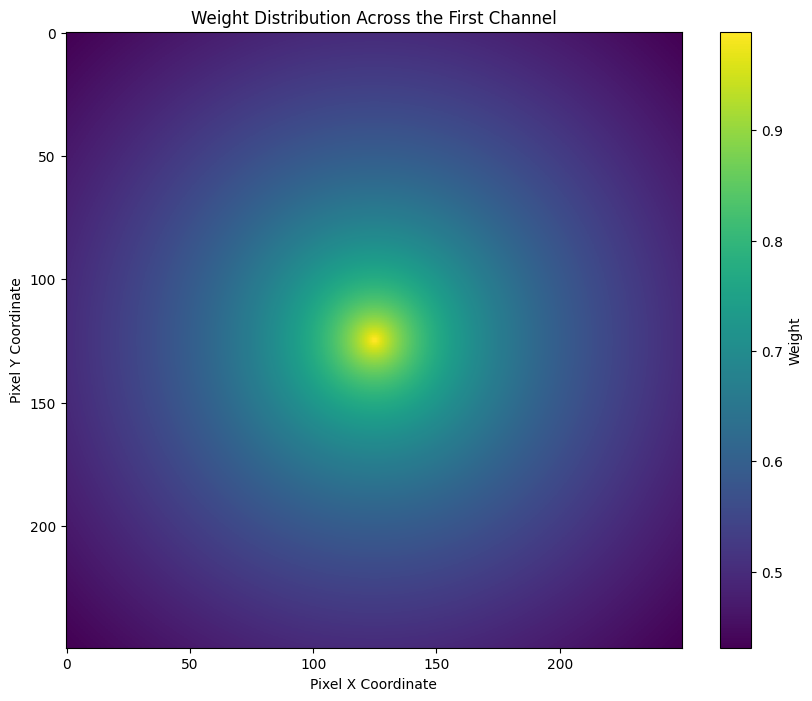

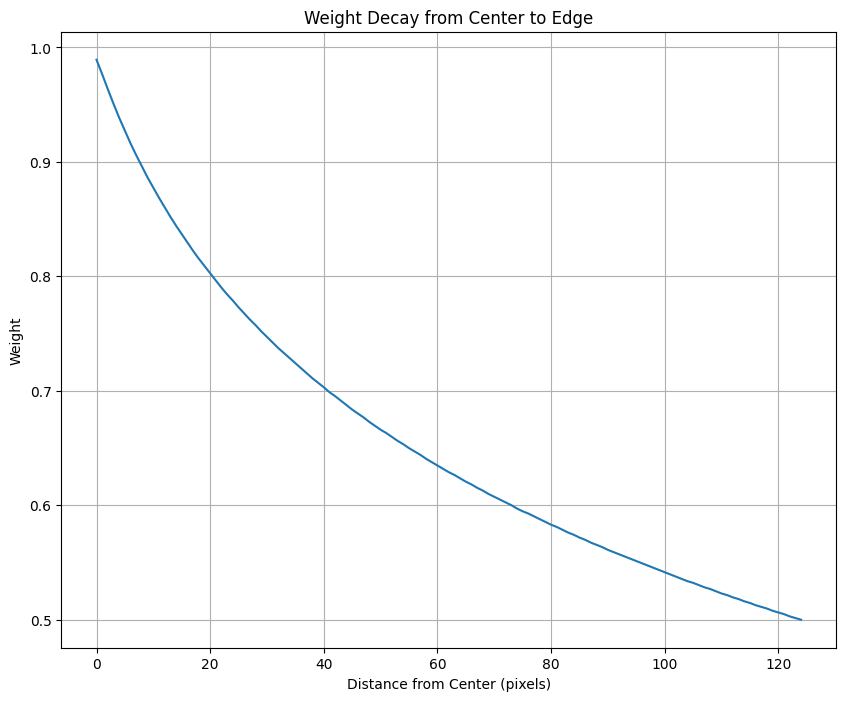

In [ ]:
import matplotlib.pyplot as plt

# 假设 decay_matrix 是您前面创建的权重衰减矩阵
# 从中心点到图像边缘的权重衰减曲线
# 选取从中心到右下角的对角线作为可视化的路径
diagonal_weights = decay_matrix[image_size//2, image_size//2:, 0]  # 取中心行，从中心列到最后一列的权重

# 可视化整个权重矩阵的第一个通道
plt.figure(figsize=(10, 8))
plt.imshow(decay_matrix[:, :, 0], cmap='viridis')
plt.colorbar(label='Weight')
plt.title('Weight Distribution Across the every Channel')
plt.xlabel('Pixel X Coordinate')
plt.ylabel('Pixel Y Coordinate')
plt.show()

# 可视化权重衰减曲线
plt.figure(figsize=(10, 8))
plt.plot(diagonal_weights)
plt.title('Weight Decay from Center to Edge')
plt.xlabel('Distance from Center (pixels)')
plt.ylabel('Weight')
plt.grid(True)
plt.show()


训练

In [ ]:
# !pip install tensorflow-addons
# from tensorflow_addons.optimizers import RectifiedAdam
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, ReLU, Add, GlobalAveragePooling3D, Dense, Multiply, Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.mixed_precision import LossScaleOptimizer



def r_squared(y_true, y_pred):
    y_true_mean = tf.reduce_mean(y_true)
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - y_true_mean))
    threshold = tf.constant(1e-5, dtype=tf.float32)
    denominator = tf.maximum(SS_tot, threshold)
    r_squared = 1 - SS_res / denominator
    return r_squared


def apply_decay(inputs):
    return inputs * decay_matrix

# Input layer
inputs = tf.keras.Input(shape=(250, 250, 84))
# Apply the decay matrix to the inputs
# 使用 Lambda 层
decayed_inputs = tf.keras.layers.Lambda(apply_decay)(inputs)
print(decayed_inputs.shape)
# decayed_inputs = inputs
# Load the EfficientNetB0 model
base_model = EfficientNetB0(include_top=False, weights=None, input_tensor=decayed_inputs)

# Build the top layers to adapt the EfficientNet to your problem
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid',dtype=tf.float32)(x)


# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# 3. 编译模型时应用梯度裁剪
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0)
# opt = RectifiedAdam(learning_rate=1e-4,clipvalue=1.0)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipvalue=1)
# 创建一个 LossScaleOptimizer
# opt = LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=1e-3,clipvalue=1), dynamic=True)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta=1.1), metrics=['mae', r_squared])


# Summarizing the Model
model.summary()


(None, 250, 250, 84)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 84)]       0         []                            
                                                                                                  
 lambda (Lambda)             (None, 250, 250, 84)         0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 250, 250, 84)         0         ['lambda[0][0]']              
                                                                                                  
 normalization (Normalizati  (None, 250, 250, 84)         169       ['rescaling[0][0]']           
 on)                                                                     

In [ ]:
model = tf.keras.models.load_model('/content/best_model1_729.h5',custom_objects={'decay_matrix': decay_matrix, 'r_squared':r_squared})
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
# 创建一个 LossScaleOptimizer
# opt = LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=1e-3,clipvalue=1), dynamic=True)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta=1.1), metrics=['mae', r_squared])

Epoch 1/100
   1179/Unknown - 609s 457ms/step - loss: 0.0118 - mae: 0.1270 - r_squared: -0.4495

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1179/1179 [==============================] - 642s 485ms/step - loss: 0.0118 - mae: 0.1270 - r_squared: -0.4495 - val_loss: 0.0086 - val_mae: 0.1065 - val_r_squared: -0.5613
Epoch 2/100
1179/1179 [==============================] - 588s 479ms/step - loss: 0.0108 - mae: 0.1211 - r_squared: -0.2151 - val_loss: 0.0129 - val_mae: 0.1318 - val_r_squared: -3.8815
Epoch 3/100
1179/1179 [==============================] - 595s 483ms/step - loss: 0.0111 - mae: 0.1230 - r_squared: -0.2415 - val_loss: 0.0103 - val_mae: 0.1237 - val_r_squared: -0.3732
Epoch 4/100
1179/1179 [==============================] - 599s 488ms/step - loss: 0.0109 - mae: 0.1219 - r_squared: -0.2135 - val_loss: 0.0096 - val_mae: 0.1164 - val_r_squared: -0.1029
Epoch 5/100
1179/1179 [==============================] - 582s 479ms/step - loss: 0.0109 - mae: 0.1225 - r_squared: -0.2248 - val_loss: 0.0085 - val_mae: 0.1121 - val_r_squared: -0.1329
Epoch 6/100
1179/1179 [==============================] - 603s 487ms/step - loss: 0.0109

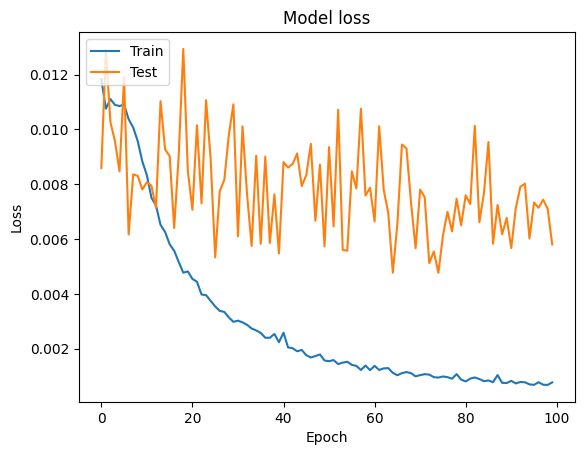

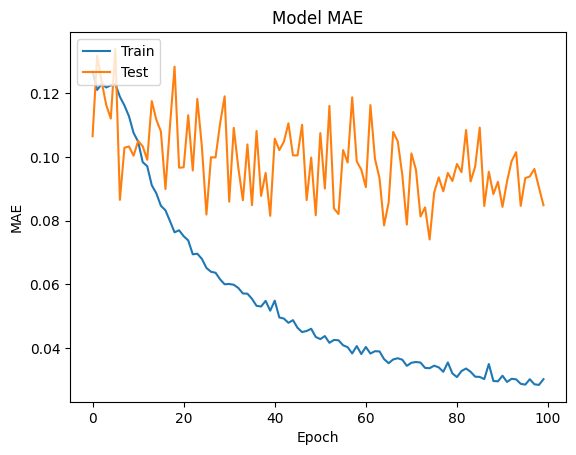

In [ ]:
import tensorflow.keras.callbacks as callbacks

# 1. 设置Early Stopping和Model Checkpoint回调
# early_stopping = callbacks.EarlyStopping(patience=50, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_mae')


# 3. 训练代码
history = model.fit(
    train_dataset,
    epochs=150,
    validation_data=val_dataset,
    callbacks=[model_checkpoint]
)

# 保存最终模型
model.save('EfficientNet150epoch_ver1.h5')

# 可视化训练过程
import matplotlib.pyplot as plt

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的MAE值
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
# +-3dBA
# 1. 定义自定义损失函数
def custom_loss(y_true, y_pred):
    # 反归一化
    y_true_denorm = y_true * (100.1 - 39.1) + 39.1
    y_pred_denorm = y_pred * (100.1 - 39.1) + 39.1

    # 转换为float32类型
    y_true_denorm = tf.cast(y_true_denorm, tf.float32)
    y_pred_denorm = tf.cast(y_pred_denorm, tf.float32)

    # 计算基本的均方误差
    mse_loss = tf.reduce_mean(tf.square(y_true_denorm - y_pred_denorm))

    # 计算额外的惩罚项
    penalty_threshold = 0.57
    penalty_factor = 2.0  # 惩罚因子，可以根据需要调整
    penalty_mask = tf.cast(y_true > penalty_threshold, dtype=tf.float32)
    penalty_term = penalty_factor * tf.reduce_mean(penalty_mask * tf.square(y_true_denorm - y_pred_denorm))

    # 新增: 处理声学不确定性
    uncertainty_margin = 3.0
    delta = tf.abs(y_true_denorm - y_pred_denorm) - uncertainty_margin
    uncertainty_penalty = tf.where(delta > 0, delta, 0)  # 如果差异大于3dBA, 则计算差异，否则为0
    uncertainty_penalty_term = tf.reduce_mean(tf.square(uncertainty_penalty))  # 平方并求均值

    # 将基本损失、惩罚项和不确定性惩罚项结合起来
    total_loss = mse_loss + penalty_term + uncertainty_penalty_term

    return total_loss


In [ ]:
# 中断后接着训练
# 创建一个ModelCheckpoint回调
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',  # 模型文件路径
    monitor='val_loss',  # 需要监控的指标
    save_best_only=True,  # 仅保存最佳模型
    verbose=1  # 日志级别
)

# 在fit函数中使用这个回调
history = model.fit(
    train_dataset,
    epochs=20,  # 假设训练20个周期
    validation_data=val_dataset,
    callbacks=[checkpoint_callback]  # 添加回调列表
)

# 如果训练中断，您可以从最佳模型重新开始
# 首先加载模型
model = tf.keras.models.load_model('best_model.h5', custom_objects={'custom_loss': custom_loss})

# 然后继续训练
model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback]
)

权重衰减矩阵3D
```



In [ ]:
import tensorflow as tf
import numpy as np

# Assuming input shape is (250, 250, 84, 1) for your multispectral data
image_size = 250
x_coords = tf.linspace(-(image_size//2), image_size//2, image_size)
y_coords = tf.linspace(-(image_size//2), image_size//2, image_size)
x_coords, y_coords = tf.meshgrid(x_coords, y_coords)

# Convert the data type to float32
x_coords = tf.cast(x_coords, tf.float32)
y_coords = tf.cast(y_coords, tf.float32)

d = tf.sqrt(tf.square(x_coords) + tf.square(y_coords))
d_normalized = 1 + d / tf.reduce_max(d)
decay = 1 - 0.05 * tf.math.log(d_normalized)
decay = tf.clip_by_value(decay, 0, 1)
decay = decay[tf.newaxis, :, :, tf.newaxis, tf.newaxis]
decay_matrix = tf.convert_to_tensor(decay, dtype=tf.float32)  # Now decay is already float32, so no error should occur

print(decay_matrix.shape)  # Should output: (1, 250, 250, 1, 1)


(1, 250, 250, 1, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, ReLU, Add, GlobalAveragePooling3D, Dense, Multiply, Concatenate
from tensorflow.keras import regularizers


def r_squared(y_true, y_pred):
    y_true_mean = tf.reduce_mean(y_true)
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - y_true_mean))
    threshold = tf.constant(1e-5, dtype=tf.float32)
    denominator = tf.maximum(SS_tot, threshold)
    r_squared = 1 - SS_res / denominator
    return r_squared


# 1. 定义自定义损失函数
def custom_loss(y_true, y_pred):
    # 反归一化
    y_true_denorm = y_true * (100.1 - 39.1) + 39.1
    y_pred_denorm = y_pred * (100.1 - 39.1) + 39.1

    # 转换为float32类型
    y_true_denorm = tf.cast(y_true_denorm, tf.float32)
    y_pred_denorm = tf.cast(y_pred_denorm, tf.float32)

    # 计算基本的均方误差
    mse_loss = tf.reduce_mean(tf.square(y_true_denorm - y_pred_denorm))

    # 计算额外的惩罚项
    penalty_threshold = 0.57
    penalty_factor = 1.5  # 惩罚因子，可以根据需要调整
    penalty_mask = tf.cast(y_true > penalty_threshold, dtype=tf.float32)
    penalty_term = penalty_factor * tf.reduce_mean(penalty_mask * tf.square(y_true_denorm - y_pred_denorm))

    # 将基本损失和惩罚项结合起来
    total_loss = mse_loss + penalty_term

    return total_loss



def res_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x

    # First convolution layer
    x = Conv3D(filters, kernel_size=kernel_size, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = ReLU()(x)

    # Second convolution layer with stride 1
    x = Conv3D(filters, kernel_size=kernel_size, strides=1, padding="same")(x)
    x = BatchNormalization()(x)  # Batch Normalization

    # Adjusting the shortcut for addition if necessary
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = Conv3D(filters, kernel_size=1, strides=stride, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)  # Batch Normalization

    # Adding the shortcut to the output
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_res_3dcnn(input_shape, decay_matrix):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv3D(32, (3, 3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)  # Batch Normalization
    x = ReLU()(x)

    # Apply decay weight matrix
    x = Multiply()([x, decay_matrix])

    # Residual Blocks
    x = res_block(x, 32)
    x = res_block(x, 32)
    x = res_block(x, 64, stride=2)
    x = res_block(x, 64)
    x = res_block(x, 128, stride=2)
    x = res_block(x, 128)

    # Global Average Pooling Layer
    x = GlobalAveragePooling3D()(x)

    # Fully Connected Layer (Dense Layer)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    output = Dense(1, activation='linear')(x)  # Assuming regression task

    # Creating the Model
    model = Model(inputs=inputs, outputs=output)

    return model

# Assuming input shape is (250, 250, 84, 1) for your multispectral data
input_shape = (250, 250, 84, 1)
model = build_res_3dcnn(input_shape, decay_matrix)

# 3. 编译模型时应用梯度裁剪
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0)
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipvalue=1.0)
model.compile(optimizer=optimizer, loss=custom_loss, metrics=['mae'])

# Summarizing the Model
model.summary()
